# Map statistics

In [11]:
from mdx2.utils import loadobj
import pandas as pd
import numpy as np

Crystal  = loadobj('mdx2/split_00/geometry.nxs','crystal')
Symmetry = loadobj('mdx2/split_00/geometry.nxs','symmetry')

def hkl2s(h,k,l):
    """Compute the magnitude of s from Miller indices."""
    UB = Crystal.ub_matrix
    s = UB @ np.stack((h,k,l))
    return np.sqrt(np.sum(s*s,axis=0))

def isInteger(h):
    return (h.round()-h).abs() < 0.00001

def isReflection(h,k,l):
    return isInteger(h) & isInteger(k) & isInteger(l) & Symmetry.is_reflection(h,k,l)

def load_refl(fn):
    t1 = loadobj(fn,'hkl_table')
    t1.s = hkl2s(t1.h,t1.k,t1.l)
    df1 = t1.to_frame()
    df1h = df1[isReflection(df1['h'],df1['k'],df1['l'])].set_index(['h','k','l'])
    df1 = df1[~isReflection(df1['h'],df1['k'],df1['l'])].set_index(['h','k','l'])
    return df1, df1h

def calc_stats(df):
    # divide into 100 equal sized bins
    s_bins = pd.cut(df['s'],np.linspace(0.03,.8,78))

    # compute statistics in each bin
    df_isoavg = df.groupby(s_bins).agg({
        's':'mean',
        'intensity':['mean','std'],
        'intensity_error':'mean'})
    df_isoavg.columns = df_isoavg.columns.to_flat_index()
    df_isoavg = df_isoavg.rename(columns={('s', 'mean'): "s", ('intensity','std'):'standard deviation', ('intensity','mean'):'mean', ('intensity_error','mean'):'average measurement error'})
    df_isoavg = df_isoavg.set_index('s')
    return df_isoavg

# read merged data and normalize
df0, df0h = load_refl('mdx2/merged_all.nxs')
df0f, df0fh = load_refl('mdx2/merged_all_Friedel.nxs')
df1, df1h = load_refl('mdx2/merged_crystal1.nxs')
df2, df2h = load_refl('mdx2/merged_crystal2.nxs')

df0_stats = calc_stats(df0)
df0h_stats = calc_stats(df0h)
df1_stats = calc_stats(df1)
df1h_stats = calc_stats(df1h)
df2_stats = calc_stats(df2)
df2h_stats = calc_stats(df2h)

Inorm0 = df0_stats['mean'].max()
Inorm1 = df1_stats['mean'].max()
Inorm2 = df2_stats['mean'].max()

df0_stats /= Inorm0
df0h_stats /= Inorm0
df1_stats /= Inorm1
df1h_stats /= Inorm1
df2_stats /= Inorm2
df2h_stats /= Inorm2

Reading crystal from ../processing/mdx2/split_00/geometry.nxs
  importing as Crystal from mdx2.geometry
Reading symmetry from ../processing/mdx2/split_00/geometry.nxs
  importing as Symmetry from mdx2.geometry
Reading hkl_table from ../processing/mdx2/merged_all.nxs
  importing as HKLTable from mdx2.data
Reading hkl_table from ../processing/mdx2/merged_all_Friedel.nxs
  importing as HKLTable from mdx2.data
Reading hkl_table from ../processing/mdx2/merged_crystal1.nxs
  importing as HKLTable from mdx2.data
Reading hkl_table from ../processing/mdx2/merged_crystal2.nxs
  importing as HKLTable from mdx2.data


## Figure 4a

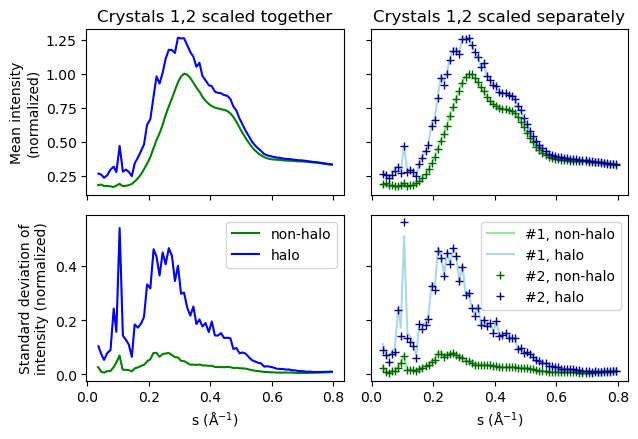

In [6]:
import matplotlib.pyplot as plt

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=True,sharey='row',figsize=(6.5,4.5))

for df,args in zip([df1_stats,df1h_stats,df2_stats,df2h_stats],
                    [dict(color='lightgreen'),
                     dict(color='lightblue'),
                     dict(color='darkgreen',marker='+',linestyle='none'),
                     dict(color='darkblue',marker='+',linestyle='none')]):
    df['mean'].plot(ax=ax2,**args)
    df['standard deviation'].plot(ax=ax4,**args)
    
df0_stats['mean'].plot(ax=ax1,color='green')
df0h_stats['mean'].plot(ax=ax1,color='blue')
df0_stats['standard deviation'].plot(ax=ax3,color='green')
df0h_stats['standard deviation'].plot(ax=ax3,color='blue')
ax3.legend(['non-halo', 'halo'])

ax1.set_title('Crystals 1,2 scaled together')
ax2.set_title('Crystals 1,2 scaled separately')
ax1.set_ylabel('Mean intensity\n(normalized)')
ax3.set_ylabel('Standard deviation of\nintensity (normalized)')
ax4.legend(['#1, non-halo',  '#1, halo', '#2, non-halo', '#2, halo'])
[ax.set_xlabel('s (Å$^{-1}$)') for ax in [ax3,ax4]]
plt.tight_layout()

#plt.savefig('figures/fig4a.png',transparent=True)

## Figure 4b

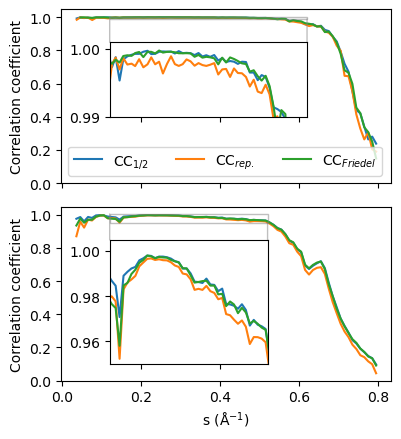

In [10]:
df0.head()

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(4.2, 4.5))

def calc_cc(df,*cols):
    s_bin = pd.cut(df.s,np.linspace(0.03,.8,78)) 
    corr_binned = df.groupby(s_bin)[list(cols)].corr(method='pearson').unstack()
    x = df.groupby(s_bin)['s'].mean().values
    y = corr_binned[cols].values
    return x,y

def calc_cc2(df1,df2,col):
    df12 = df1.merge(df2,on=('h','k','l'),suffixes=('_1','_2'))
    df12.head()
    s_bin = pd.cut(df12.s_1,np.linspace(0.03,.8,78)) 
    df_tmp = df12.groupby(s_bin)[[col+'_1',col+'_2']].corr(method='pearson').unstack()
    x = df12.groupby(s_bin)['s_1'].mean().values
    y = df_tmp[(col+'_1',col+'_2')].values
    return x,y
    
# add zoom insets
axin1 = ax1.inset_axes([0.12,0.4,0.5,0.45], transform=ax1.transData)
axin1.set_ylim(0.99,1.001)
axin1.set_xlim(0.12,0.62)
ax1.indicate_inset_zoom(axin1)

# add zoom insets
axin2 = ax2.inset_axes([0.12,0.1,0.4,0.75], transform=ax2.transData)
axin2.set_ylim(0.95,1.005)
axin2.set_xlim(0.12,0.52)
ax2.indicate_inset_zoom(axin2)
    
x,y = calc_cc(df0h,'group_0_intensity','group_1_intensity')
ax1.plot(x,y,label='CC$_{1/2}$')
axin1.plot(x,y)

x,y = calc_cc(df0,'group_0_intensity','group_1_intensity')
ax2.plot(x,y)
axin2.plot(x,y)

x,y = calc_cc2(df1h,df2h,'intensity')
ax1.plot(x,y,label='CC$_{rep.}$')
axin1.plot(x,y)

x,y = calc_cc2(df1,df2,'intensity')
ax2.plot(x,y)
axin2.plot(x,y)

x,y = calc_cc(df0fh,'group_0_intensity','group_1_intensity')
ax1.plot(x,y,label='CC$_{Friedel}$')
axin1.plot(x,y)

x,y = calc_cc(df0f,'group_0_intensity','group_1_intensity')
ax2.plot(x,y)
axin2.plot(x,y)

ax2.set_xlabel('s (Å$^{-1}$)')
[ax.set_ylabel('Correlation coefficient') for ax in [ax1,ax2]]

ax1.set_ylim(0,1.05)
ax2.set_ylim(0,1.05)

axin1.xaxis.set_ticklabels([])
axin2.xaxis.set_ticklabels([])

ax1.legend(ncol=3)

plt.tight_layout()

#plt.savefig('figures/fig4b.png',transparent=True)